# Data preparation

## Lấy dữ liệu comment sản phẩm từ Shopee

In [ ]:
import re
import json
import requests
import pandas as pd

def get_cmt_from_shopee_url(url):

    r = re.search(r"i\.(\d+)\.(\d+)", url)
    shop_id, item_id = r[1], r[2]
    ratings_url = "https://shopee.vn/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=50&offset={offset}&shopid={shop_id}&type={rating}"

    # d = {"username": [], "rating": [], "comment": []}
    d = {"comment": [], "rating": []}

    for rate in range(1, 6):
        offset = 0
        while True:
            try:
              data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset, rating = rate)).json()

              i = 1
              for i, rating in enumerate(data["data"]["ratings"], 1):
                  d["rating"].append(rating["rating_star"])
                  d["comment"].append(rating["comment"])

                  # print(rating["rating_star"])
                  # print(rating["comment"])
                  # print("-" * 100)

              offset += 50
            except TypeError:
              break
    return d

In [ ]:
url = "https://shopee.vn/S%E1%BB%AFa-r%E1%BB%ADa-m%E1%BA%B7t-Simple-l%C3%A0nh-t%C3%ADnh-s%E1%BA%A1ch-tho%C3%A1ng-cho-da-nh%E1%BA%A1y-c%E1%BA%A3m-150ml-CH%C3%8DNH-H%C3%83NG-%C4%90%E1%BB%98C-QUY%E1%BB%80N-DI%E1%BB%86N-M%E1%BA%A0O-M%E1%BB%9AI--i.111138057.8587034871"
df = pd.DataFrame(get_cmt_from_shopee_url(url))
df

,comment,rating
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1
...,...,...
11263,Công dụng:làm sạch bề da mặt\nMùi hương:không ...,5
11264,Công dụng:lamf sạch da\nMùi hương:thơm dịu\nDà...,5
11265,"Nhận hàng, cảm nhận quá tuyệt vời luôn ạ! Shop...",5
11266,Dành cho da:nhạy cảm\nMùi hương:nhẹ\nCông dụng...,5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/shopee_data_final.csv", index=False)

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11268 entries, 0 to 11267
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  11268 non-null  object
 1   rating   11268 non-null  int64 
 2   words    11268 non-null  object
 3   label    11268 non-null  object
 4   feature  11268 non-null  object
dtypes: int64(1), object(4)
memory usage: 440.3+ KB


In [ ]:
num_words = 11268

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
! pip install underthesea==6.6.0
! pip install stop-words

##Chuẩn hóa dữ liệu tiếng việt, tách từ

In [ ]:
from underthesea import sent_tokenize
from underthesea import text_normalize
from underthesea import word_tokenize

In [ ]:
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer

stop_words = get_stop_words('vi')

def remove_vietnamese_stopwords(words):
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

def assign_label(rating):
  new_class = "neutral"
  if rating>=4:
    new_class = "positive"
  elif rating<=2:
    new_class = "negative"
  return new_class

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
df['words'] = df['comment'].apply(tokenizer.tokenize)
df['words'] = df['words'].apply(remove_vietnamese_stopwords)
df['label'] = df['rating'].apply(assign_label)
df.head(5)

,comment,rating,words,label
0,Công dụng:rỬa mặt\nMùi hương:ổn\nKết cấu:gel\n...,1,Công dụng rỬa mặt Mùi hương ổn Kết cấu gel sho...,negative
1,Công dụng:sữa rửa mặt\nMùi hương:chưa biết\nDà...,1,Công dụng sữa rửa mặt Mùi hương da bình chất v...,negative
2,Dành cho da:lhuf hợp với mọi loại da\nCông dụn...,1,da lhuf hợp da Công dụng sạch da Mùi hương mùi...,negative
3,Công dụng:Rửa mặt\nMùi hương:Gần như không có\...,1,Công dụng Rửa mặt Mùi hương da da Shipper gọi ...,negative
4,Công dụng:làm sạch\nMùi hương:không biết\nDành...,1,Công dụng sạch Mùi hương da tất flashs sale 1 ...,negative


label
positive    6100
negative    3169
neutral     1999
Name: count, dtype: int64


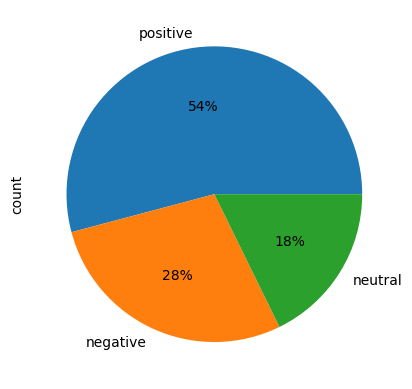

In [ ]:
import matplotlib.pyplot as plt
countClass = pd.value_counts(df['label'], sort=True, dropna=False)
print(countClass)
countClass.plot(kind = "pie", autopct= '%1.0f%%')
plt.show()

# Machine Learning

## Naive Bayes **Algorithm**

In [303]:
def create_word_features(clean_words):
    my_dict = dict([(word, True) for word in clean_words])
    return my_dict

df['feature'] = df['words'].apply(create_word_features)

In [304]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Convert text data into bag-of-words features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['words'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)


# Initialize and train the Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = NB_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.6086956521739131
              precision    recall  f1-score   support

    negative       0.58      0.49      0.53       648
     neutral       0.18      0.08      0.11       385
    positive       0.67      0.84      0.75      1221

    accuracy                           0.61      2254
   macro avg       0.47      0.47      0.46      2254
weighted avg       0.56      0.61      0.57      2254



In [305]:
print(y_test)

3520      neutral
2516     negative
3885      neutral
5270     positive
10800    positive
           ...   
3991      neutral
5998     positive
2360     negative
5606     positive
5931     positive
Name: label, Length: 2254, dtype: object


Confusion matrix, without normalization
[[ 316   54  278]
 [ 127   31  227]
 [ 104   92 1025]]
Normalized confusion matrix
[[0.48765432 0.08333333 0.42901235]
 [0.32987013 0.08051948 0.58961039]
 [0.08517609 0.07534808 0.83947584]]


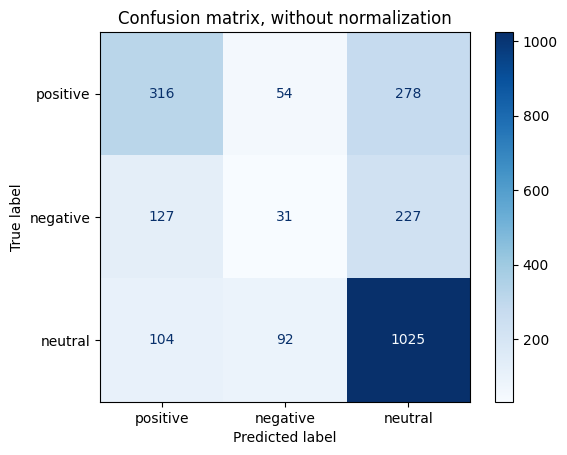

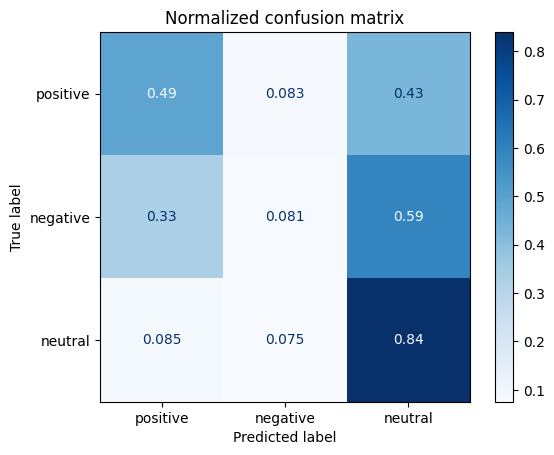

In [306]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        NB_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Support Vector Machine (SVM)

In [307]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['words'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svc_model = SVC(kernel='linear')  # You can try different kernels like 'linear', 'rbf', etc.
svc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svc_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.7058562555456965
              precision    recall  f1-score   support

    negative       0.57      0.81      0.67       648
     neutral       0.30      0.05      0.08       385
    positive       0.82      0.86      0.84      1221

    accuracy                           0.71      2254
   macro avg       0.56      0.57      0.53      2254
weighted avg       0.66      0.71      0.66      2254



Confusion matrix, without normalization
[[ 524   18  106]
 [ 247   18  120]
 [ 147   25 1049]]
Normalized confusion matrix
[[0.80864198 0.02777778 0.16358025]
 [0.64155844 0.04675325 0.31168831]
 [0.12039312 0.02047502 0.85913186]]


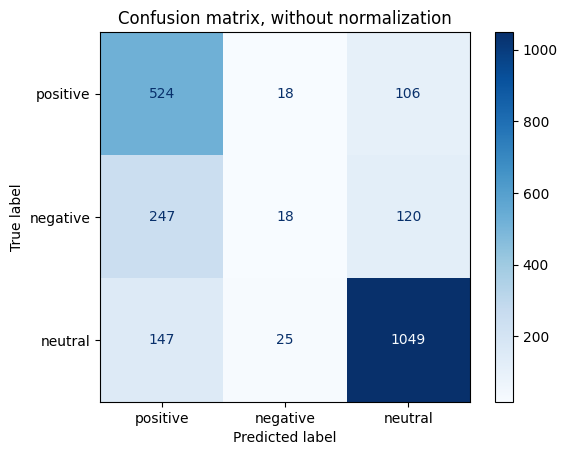

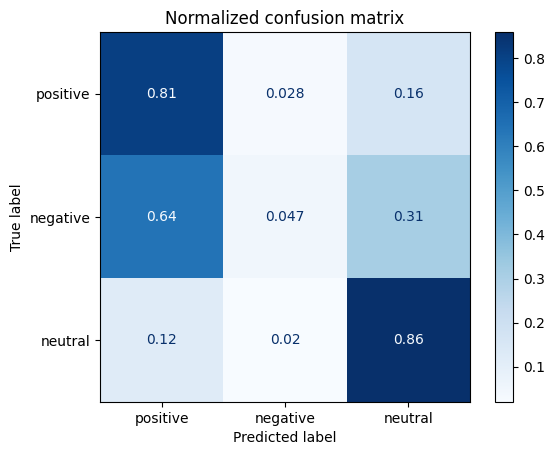

In [308]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svc_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Logistic Regression

In [309]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Check for and handle None values in the 'sentiment' column
df['label'].fillna('None', inplace=True)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["words"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df["label"], test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.7111801242236024
              precision    recall  f1-score   support

    negative       0.59      0.79      0.68       648
     neutral       0.27      0.06      0.09       385
    positive       0.82      0.87      0.85      1221

    accuracy                           0.71      2254
   macro avg       0.56      0.57      0.54      2254
weighted avg       0.66      0.71      0.67      2254



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix, without normalization
[[ 514   22  112]
 [ 244   22  119]
 [ 116   38 1067]]
Normalized confusion matrix
[[0.79320988 0.03395062 0.17283951]
 [0.63376623 0.05714286 0.30909091]
 [0.0950041  0.03112203 0.87387387]]


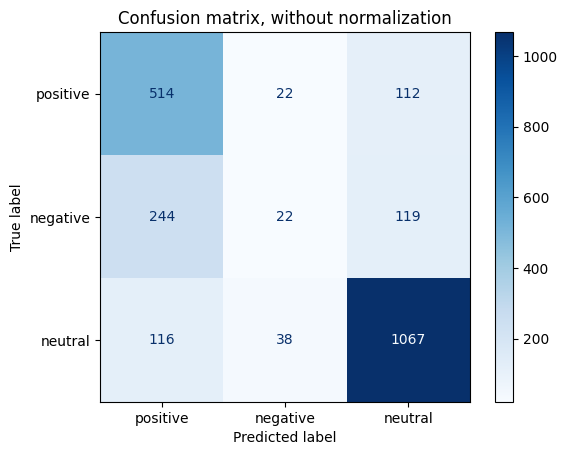

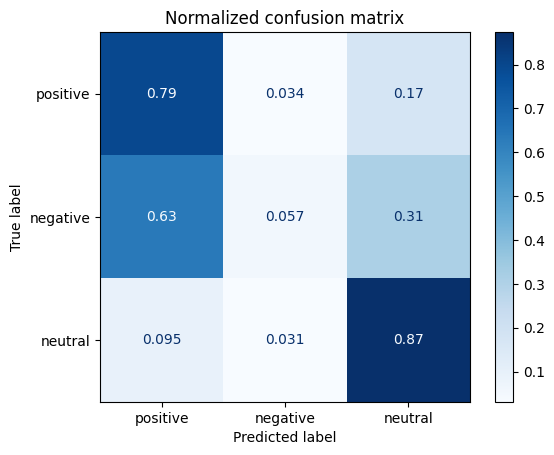

In [310]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        logistic_regression_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Decision Tree

In [311]:
# Import necessary libraries
from sklearn import tree

# Check for and handle None values in the 'sentiment' column
df['label'].fillna('None', inplace=True)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["words"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df["label"], test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.6362023070097604
              precision    recall  f1-score   support

    negative       0.53      0.66      0.59       648
     neutral       0.22      0.13      0.17       385
    positive       0.79      0.78      0.78      1221

    accuracy                           0.64      2254
   macro avg       0.51      0.53      0.51      2254
weighted avg       0.62      0.64      0.62      2254



Confusion matrix, without normalization
[[429  79 140]
 [213  51 121]
 [164 103 954]]
Normalized confusion matrix
[[0.66203704 0.12191358 0.21604938]
 [0.55324675 0.13246753 0.31428571]
 [0.13431613 0.08435708 0.78132678]]


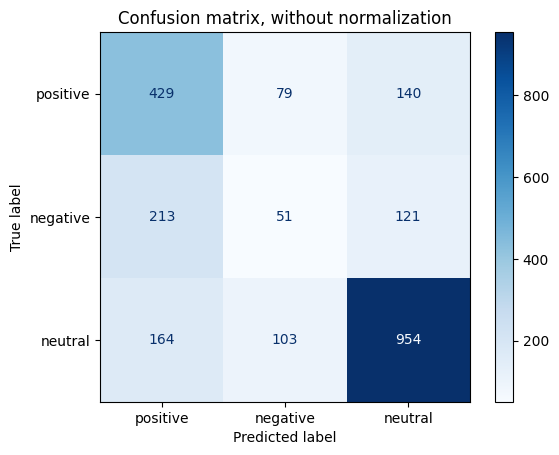

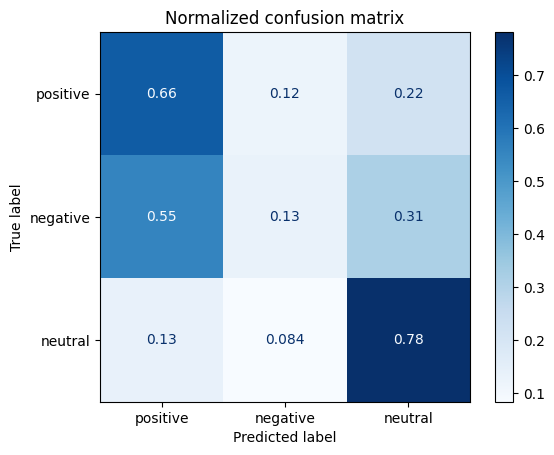

In [312]:
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        decision_tree_model,
        X_test,
        y_test,
        display_labels=["positive", "negative", "neutral"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Deep learning

In [ ]:
def create_word_features(clean_words):
    my_dict = dict([(word, True) for word in clean_words])
    return my_dict

df['feature'] = df['words'].apply(create_word_features)

In [192]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Convert text data into bag-of-words features
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['words'])

# Split the data into training and testing sets
x_train_text, x_test_text, y_train, y_test = train_test_split(x, df['words'], test_size= 0.2, random_state = 42)

In [193]:
# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [202]:
# Conver to numpy arrays
x_train_text = np.array(x_train_text)
x_test_text = np.array(x_test_text)

In [203]:
print (x_test_text[1])

Kết cấu típ Công dụng rữa mặt Mùi hương hơi hôi hàng giả hya j mn nắp vận nhìu bọt lắm nhìu hơi hôi


In [204]:
print (x_train_text[1])

Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm


In [208]:
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

Train-set size:  9014
Test-set size:   2254


In [210]:
x_train_text[1]

'Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm'

**Tokenization**


In [211]:
num_words = 10000000

In [212]:
tokenizer = Tokenizer(num_words=num_words)

In [213]:
%%time
tokenizer.fit_on_texts(df['comment'])

CPU times: user 492 ms, sys: 6.43 ms, total: 499 ms
Wall time: 522 ms


In [214]:
if num_words is None:
    num_words = len(tokenizer.word_index)

In [ ]:
tokenizer.word_index

In [216]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

In [217]:
x_train_text[1]

'Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm'

In [218]:
np.array(x_train_tokens[1])

array([ 33,  31,  14,  22,  16,  76,  77, 105, 149,  20,  22,  35, 253,
        68,  25,  23,  66])

In [219]:
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

Padding and Truncating Data

In [220]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [221]:
np.mean(num_tokens)

15.620962016329429

The maximum number of tokens in a sequence is:

In [222]:
np.max(num_tokens)

329

The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [223]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

41

In [ ]:
This covers about 95% of the data-set.

In [224]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9751508697195598

When padding or truncating the sequences that have a different length, we need to determine if we want to do this padding or truncating 'pre' or 'post'. If a sequence is truncated, it means that a part of the sequence is simply thrown away. If a sequence is padded, it means that zeros are added to the sequence.

So the choice of 'pre' or 'post' can be important because it determines whether we throw away the first or last part of a sequence when truncating, and it determines whether we add zeros to the beginning or end of the sequence when padding. This may confuse the Recurrent Neural Network.

In [225]:
pad = 'pre'

In [226]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [227]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:

In [228]:
x_train_pad.shape

(9014, 41)

The matrix for the test-set has the same shape:

In [229]:
x_test_pad.shape


(2254, 41)

In [231]:
np.array(x_train_tokens[1])

array([ 33,  31,  14,  22,  16,  76,  77, 105, 149,  20,  22,  35, 253,
        68,  25,  23,  66])

This has simply been padded to create the following sequence. Note that when this is input to the Recurrent Neural Network, then it first inputs a lot of zeros. If we had padded 'post' then it would input the integer-tokens first and then a lot of zeros. This may confuse the Recurrent Neural Network.

In [232]:
x_train_pad[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  33,  31,
        14,  22,  16,  76,  77, 105, 149,  20,  22,  35, 253,  68,  25,
        23,  66], dtype=int32)

##Tokenizer Inverse Map

In [257]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [258]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]

    # Concatenate all words.
    text = " ".join(words)

    return text

In [259]:
x_train_text[1]

'Sản phẩm giao đóng gói cẩn thận hình Nắp ko đóng Cảm giác srm k sạch lắm'

In [260]:
tokens_to_string(x_train_tokens[1])

'sản phẩm giao đóng gói cẩn thận hình nắp ko đóng cảm giác srm k sạch lắm'

##Create the Recurrent Neural Network

In [336]:
# Xây dựn mô hình RNN
model = Sequential()

In [337]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (num_words) and the length of the padded token-sequences (max_tokens). We also give this layer a name because we need to retrieve its weights further below.

In [338]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [339]:
model.add(GRU(units=16, return_sequences=True))

In [340]:
model.add(GRU(units=8, return_sequences=True))

In [341]:
model.add(GRU(units=4))

In [342]:
model.add(Dense(1, activation='sigmoid'))

In [343]:
optimizer = Adam(lr=1e-3)

In [344]:
# Biên dịch mô hình
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [345]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding  (None, 41, 8)             80000000  
 )                                                               
                                                                 
 gru_7 (GRU)                 (None, 41, 16)            1248      
                                                                 
 gru_8 (GRU)                 (None, 41, 8)             624       
                                                                 
 gru_9 (GRU)                 (None, 4)                 168       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 80002045 (305.18 MB)
Trainable params: 80002045 (305.18 MB)
Non-trainable params: 0 (0.00 Byte)
__________

##Train the Recurrent Neural Network


We can now train the model. Note that we are using the data-set with the paddedsequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [354]:
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)

Epoch 1/3


UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-348-322b6293dcdb>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_35054]

In [334]:
print(x_train_pad)

[[  0   0   0 ... 151  14   3]
 [  0   0   0 ...  25  23  66]
 [  0   0   0 ... 211 243 235]
 ...
 [  0   0   0 ...  72  50 127]
 [  0   0   0 ...  11  10 304]
 [  0   0   0 ...  16 244  61]]


In [335]:
print(y_train)

10107    positive
6345     positive
8627     positive
11202    positive
8902     positive
           ...   
5734     positive
5191     positive
5390     positive
860      negative
7270     positive
Name: label, Length: 9014, dtype: object


## Example of Mis-Classified Text

In [355]:
%%time
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

32/32 [==============================] - 3s 15ms/step
CPU times: user 2.43 s, sys: 27.5 ms, total: 2.46 s
Wall time: 3.09 s


In [356]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

In [357]:
cls_true = np.array(y_test[0:1000])

In [358]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

In [359]:
len(incorrect)

1000

In [360]:
idx = incorrect[0]
idx

0

In [361]:
text = x_test_text[idx]
text

'Công dụng sữa rửa mặt Mùi hương mùi rr tặng kèm'

In [362]:
y_pred[idx]

0.49974903

In [363]:
cls_true[idx]

'neutral'

## New Data

In [387]:
text1 = "Sản phẩm rất tuyệt mọi người nên dùng thử"
text2 = "Sản phẩm tốt"
text3 = "Tôi thích sản phẩm này"
text4 = "Bình thường"
text5 = "Ok"
text6 = "Sản phẩm không phù hợp"
text7 = "Sản phẩm tệ, kém chất lượng"
text8 = "Tôi không thích sản phẩm này, có thể hoàn tiền lại không?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

In [388]:
tokens = tokenizer.texts_to_sequences(texts)

In [389]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
tokens_pad.shape

(8, 41)

In [390]:
model.predict(tokens_pad)

1/1 [==============================] - 0s 27ms/step


array([[0.49987912],
       [0.50144464],
       [0.5009449 ],
       [0.5033725 ],
       [0.5053494 ],
       [0.50115293],
       [0.50217414],
       [0.50000995]], dtype=float32)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Embeddings

In [391]:
layer_embedding = model.get_layer('layer_embedding')

In [392]:
weights_embedding = layer_embedding.get_weights()[0]

In [393]:
weights_embedding.shape

(10000000, 8)

In [394]:
token_good = tokenizer.word_index['tốt']
token_good

57

In [395]:
token_great = tokenizer.word_index['tuyệt']
token_great

347

In [396]:
weights_embedding[token_good]

array([ 0.04822976,  0.02269096,  0.0316406 ,  0.03197749, -0.02371718,
       -0.03066554, -0.0328313 , -0.02252905], dtype=float32)

In [397]:
weights_embedding[token_great]

array([ 0.02301819, -0.01788799,  0.02528591,  0.02582607, -0.03780439,
        0.01578989,  0.03707508,  0.04175296], dtype=float32)

In [398]:
token_bad = tokenizer.word_index['dở']
token_horrible = tokenizer.word_index['tệ']

In [399]:
weights_embedding[token_bad]

array([ 0.02932965,  0.0100602 ,  0.0463735 ,  0.04909874,  0.0393086 ,
       -0.02156348, -0.03684862, -0.0223927 ], dtype=float32)

In [400]:
weights_embedding[token_horrible]

array([ 0.03097817, -0.02008927,  0.03174641, -0.02956401, -0.00341891,
       -0.02099822, -0.04902026,  0.01512358], dtype=float32)

## Sorted Words
We can also sort all the words in the vocabulary according to their "similarity" in the embedding-space. We want to see if words that have similar embedding-vectors also have similar meanings.

Similarity of embedding-vectors can be measured by different metrics, e.g. Euclidean distance or cosine distance.

We have a helper-function for calculating these distances and printing the words in sorted order.

In [402]:
def print_sorted_words(word, metric='cosine'):

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]

    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)

    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]

    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

In [403]:
print_sorted_words('good', metric='cosine')

KeyError: 417177

In [386]:
print_sorted_words('tệ', metric='cosine')

KeyError: 932836